In [38]:
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import sys
import pandas as pd

if '../code' not in sys.path:
    sys.path.append('../code')

from info_architecture import Node, InfoArchTree, _find_sep, generate_treemap, plot_treemap

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
arr = np.zeros((12, 12), dtype=np.int16)

arr[0:12, 0:2] = 1
arr[0:2, 2:] = 2
arr[2:8, 2:6] = 3
arr[2:8, 6:12] = 4
arr[8:10, 2:] = 5
arr[10:12, 2:] = 6

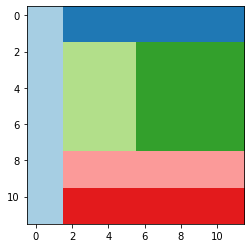

In [3]:
plt.imshow(arr, cmap='Paired', vmax=12);

In [4]:
arr2 = np.zeros_like(arr)

arr2[0:12, 0:3] = 1
arr2[0:8, 3:] = 2
arr2[8:, 3:6] = 3
arr2[8:, 6:9] = 4
arr2[8:, 9:12] = 5

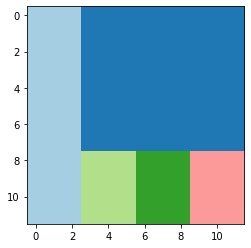

In [5]:
plt.imshow(arr2, cmap='Paired', vmax=12);

In [6]:
ia = InfoArchTree.from_array(arr, 12, 12)
ia2 = InfoArchTree.from_array(arr2, 12, 12)

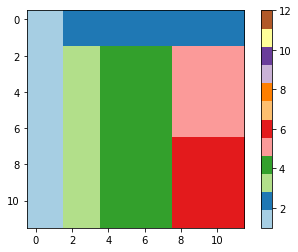

In [7]:
ia.plot();

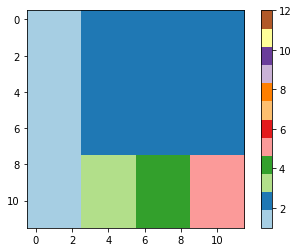

In [8]:
ia2.plot();

In [9]:
print(ia)

[], 1.00
|----1, 0.17, v
|----[], 0.83
|    |----2, 0.17, h
|    |----[], 0.83
|    |    |----[], 0.60
|    |    |    |----3, 0.40, v
|    |    |    |----4, 0.60, v
|    |    |----[], 0.40
|    |    |    |----5, 0.50, h
|    |    |    |----6, 0.50, h


In [10]:
print(ia2)

[], 1.00
|----1, 0.25, v
|----[], 0.75
|    |----2, 0.67, h
|    |----[], 0.33
|    |    |----3, 0.33, v
|    |    |----[], 0.67
|    |    |    |----4, 0.50, v
|    |    |    |----5, 0.50, v


In [11]:
ia.get_features()

,value,size,orientation,depth
0,1,0.166667,1,0.2
1,2,0.138889,0,0.4
2,3,0.166667,1,0.8
3,4,0.250000,1,0.8
4,5,0.138889,0,0.8
5,6,0.138889,0,1.0


In [12]:
ia2.get_features()

,value,size,orientation,depth
0,1,0.250000,1,0.2
1,2,0.500000,0,0.4
2,3,0.083333,1,0.6
3,4,0.083333,1,0.8
4,5,0.083333,1,1.0


In [15]:
ia.distance(ia2)

3.2888888888888888

### Randomly generating treemaps


* Randomly generate a bunch of treemaps
* Compute similarities
* Plot them to see if it makes sense
* Try a bunch of different similarity functions

In [16]:
arr = np.array([
    [1, 2, 3],
    [4, 5, 6],
    [6, 7, 8],
    [9, 8, 7]
])

In [17]:
np.split(arr, [1], axis=0)

[array([[1, 2, 3]]),
 array([[4, 5, 6],
        [6, 7, 8],
        [9, 8, 7]])]

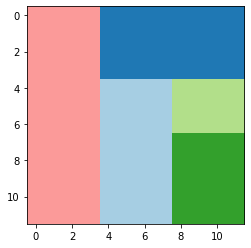

In [18]:
plot_treemap(generate_treemap())

In [19]:
treemaps = []
while len(treemaps) < 12:
    try:
        treemaps.append(generate_treemap())
    except ValueError:
        print("Failure")

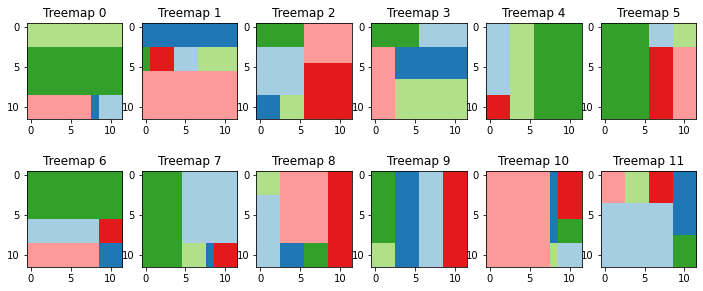

In [20]:
fig, axs = plt.subplots(2, 6, figsize=(12, 5))
for i, (treemap, ax) in enumerate(zip(treemaps, axs.flat)):
    plot_treemap(treemap, ax=ax)
    ax.set_title(f"Treemap {i}")
plt.show()

### Generating by hand

In [25]:
# Defined by lists of (row1, col1, height, width) tuples
arr1 = [
    (0, 0, 12, 2),
    (0, 2, 4, 10),
    (4, 2, 6, 10),
    (10, 2, 2, 10)
]
arr2 = [
    (0, 0, 2, 5),
    (0, 5, 2, 5),
    (0, 10, 12, 2),
    (2, 0, 6, 5),
    (2, 5, 6, 5),
    (8, 0, 4, 10),
    (0, 10, 12, 2)
]
arr3 = [
    (0, 0, 12, 3),
    (0, 3, 2, 6),
    (2, 3, 8, 6),
    (8, 3, 4, 6),
    (0, 9, 12, 3)
]
arr4 = [
    (0, 0, 7, 12),
    (7, 0, 5, 4),
    (7, 4, 5, 4),
    (7, 8, 5, 4)
]
arr5 = [
    (0, 0, 9, 10),
    (8, 0, 3, 12),
    (0, 10, 3, 2),
    (3, 10, 3, 2),
    (6, 10, 3, 2)
]

In [26]:
def spec2arr(spec, height=12, width=12, n_components=8):
    components = np.random.choice(n_components, size=len(spec), replace=False) + 1
    arr = np.zeros((height, width))
    spec = np.random.permutation(spec)
    for i, comp in zip(range(spec.shape[0]), components):
        r1, c1, h, w = spec[i]
        arr[r1:r1 + h, c1:c1 + w] = comp
    return arr

In [27]:
treemaps = []
info_archs = []
for arch in [arr1, arr2, arr3, arr4, arr5]:
    for i in range(20):
        arr = spec2arr(arch)
        treemaps.append(arr)
        try:
            info_archs.append(InfoArchTree.from_array(arr))
        except:
            pass

In [28]:
len(treemaps)

100

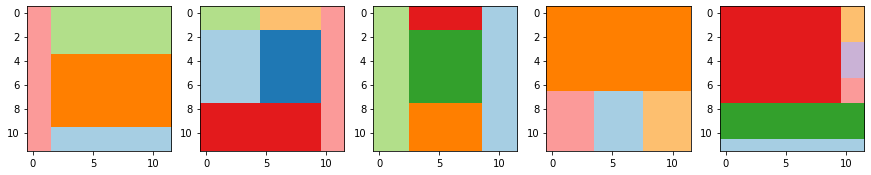

In [47]:
fig, axs = plt.subplots(1, 5, figsize=(5 * 3, 1 * 3))
for treemap, ax in zip(treemaps[::20], axs.flat):
    plot_treemap(treemap, ax=ax)

In [30]:
def compute_distances(info_archs, distance_func=None, args=None):
    distances = np.zeros((len(info_archs), len(info_archs)))
    with tqdm(total=len(info_archs) ** 2) as pbar:
        for i in range(len(info_archs)):
            for j in range(len(info_archs)):
                distances[i, j] = info_archs[i].distance(info_archs[j], distance_func=distance_func, args=args)
                pbar.update()
    return distances

In [31]:
def weighted_distance(feats1, feats2, weights):
    weights = weights.reshape(1, feats1.shape[1])
    return np.abs((feats1 - feats2) * weights).sum()

In [39]:
distances = compute_distances(info_archs)
distances /= distances.max()

100%|██████████| 9216/9216 [02:42<00:00, 56.61it/s]


In [40]:
weights = np.array([5, .5, 2])
distances_weighted = compute_distances(info_archs, distance_func=weighted_distance, args=(weights,))
distances_weighted /= distances_weighted.max()

100%|██████████| 9216/9216 [02:38<00:00, 58.24it/s]


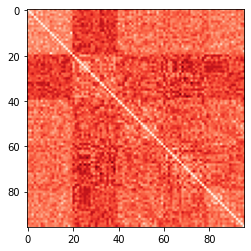

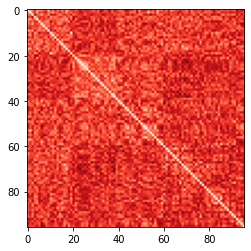

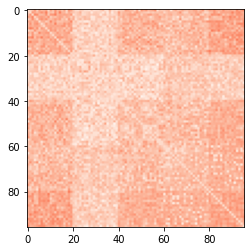

In [41]:
plt.imshow(distances, cmap='Reds', vmax=1.)
plt.show()
plt.imshow(distances_weighted, cmap='Reds', vmax=1.)
plt.show()
plt.imshow(distances_weighted - distances, cmap='Reds', vmax=1.);

In [42]:
weights2 = np.array([1, 0, 0])
distances_size_only = compute_distances(info_archs, distance_func=weighted_distance, args=(weights2,))
distances_size_only /= distances_size_only.max()

100%|██████████| 9216/9216 [02:31<00:00, 60.82it/s]


In [43]:
weights3 = np.array([0, 0, 1])
distances_depth_only = compute_distances(info_archs, distance_func=weighted_distance, args=(weights3,))
distances_depth_only /= distances_depth_only.max()

100%|██████████| 9216/9216 [02:31<00:00, 60.97it/s]


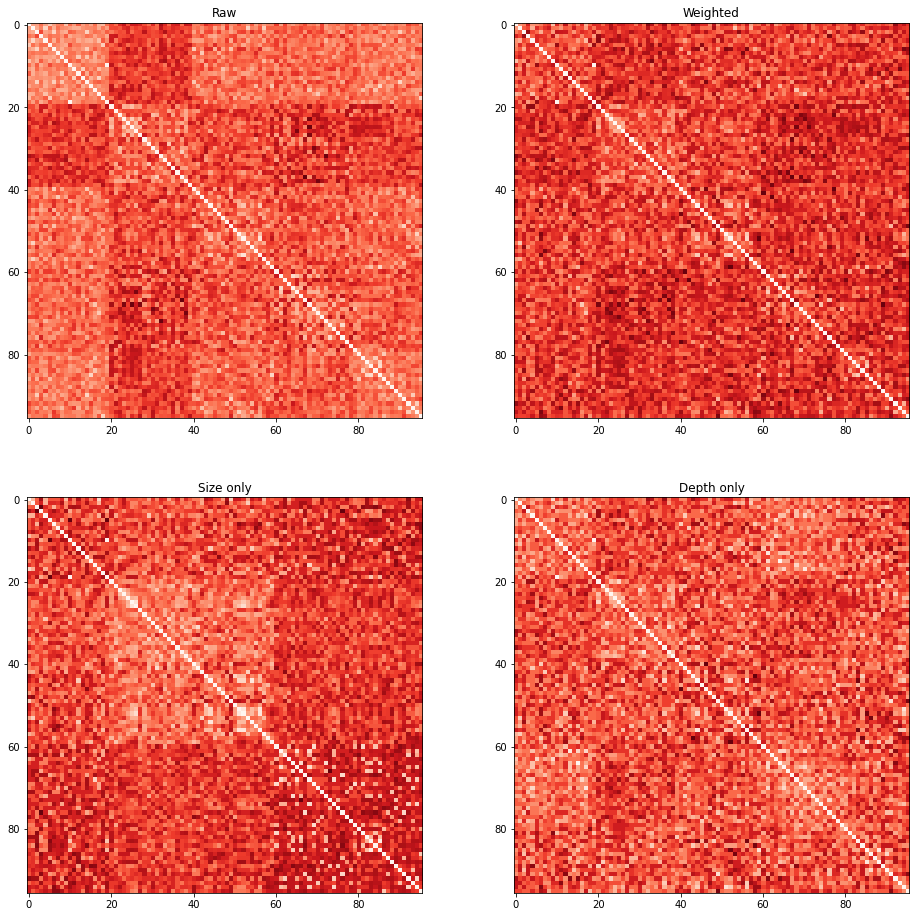

In [44]:
fig, axs = plt.subplots(2, 2, figsize=(16, 16))
for dist_mat, ax, title in zip([distances, distances_weighted, distances_size_only, distances_depth_only],
                               axs.flat,
                               ['Raw', 'Weighted', 'Size only', 'Depth only']):
    ax.imshow(dist_mat, cmap='Reds', vmax=1.)
    ax.set_title(title)
plt.show()

## Displaying the most similar DBs to a given dashboard

In [48]:
chosen_dbs = np.random.choice(len(info_archs), size=4)

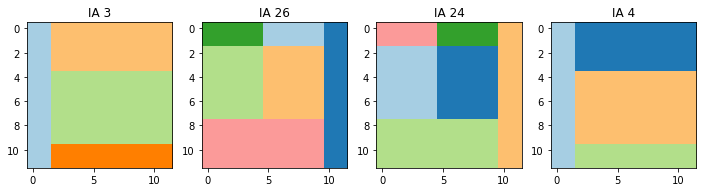

In [49]:
fig, axs = plt.subplots(1, 4, figsize=(4 * 3, 3))
for i, ax in zip(chosen_dbs, axs):
    plot_treemap(treemaps[i], ax=ax)
    ax.set_title(f"IA {i}")

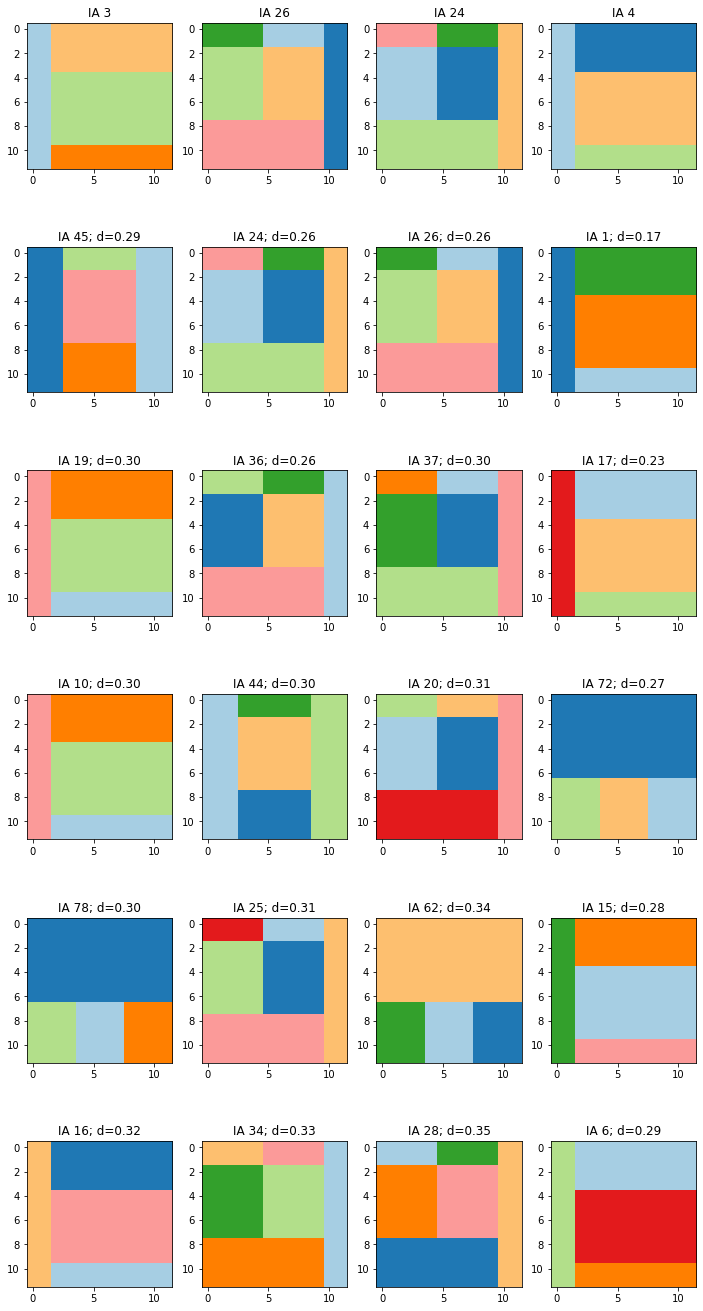

In [50]:
# Plotting 6 most similar
fig, axs = plt.subplots(6, 4, figsize=(4 * 3, 6 * 4))
for i, db_idx in enumerate(chosen_dbs):
    plot_treemap(treemaps[db_idx], ax=axs[0, i])
    axs[0, i].set_title(f"IA {db_idx}")
    
    dists = distances[db_idx]
    closest_dbs = np.argsort(dists)[1:6]    
    for j, db in enumerate(closest_dbs):
        plot_treemap(treemaps[db], ax=axs[j+1, i])
        axs[j+1, i].set_title(f"IA {db}; d={dists[db]:.2f}")

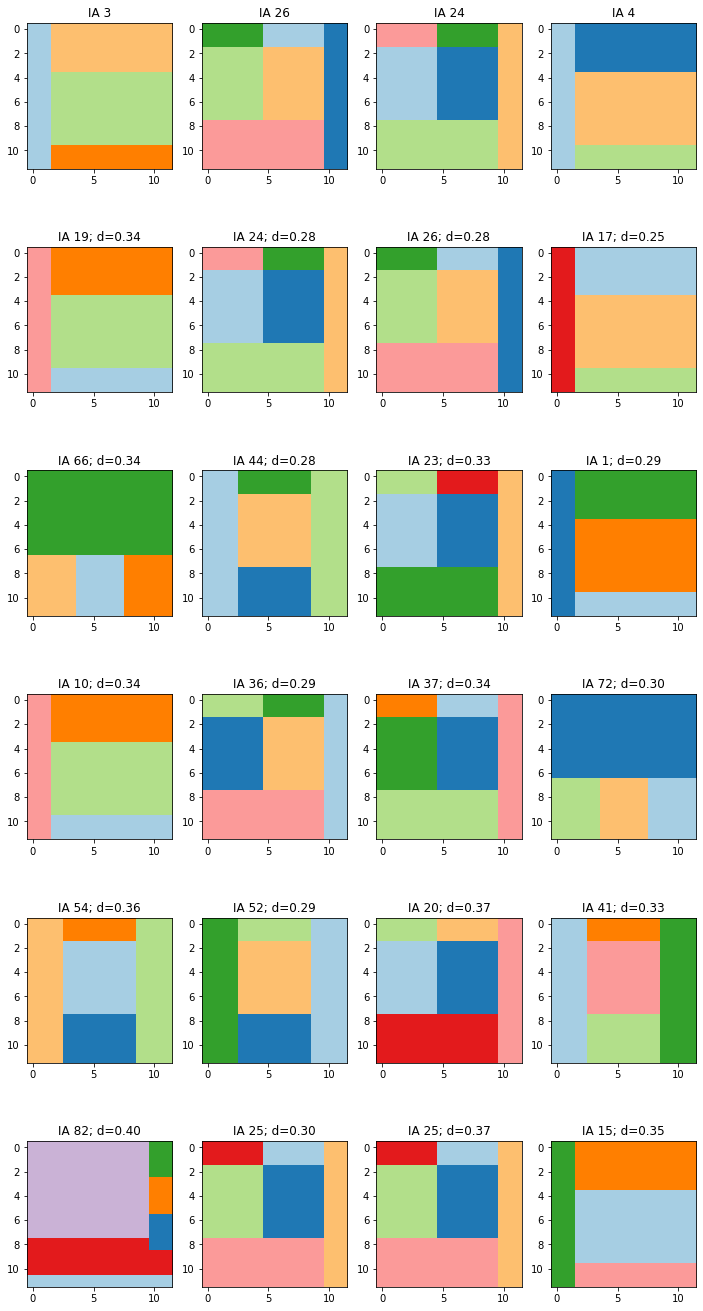

In [51]:
# Plotting 6 most similar
fig, axs = plt.subplots(6, 4, figsize=(4 * 3, 6 * 4))
for i, db_idx in enumerate(chosen_dbs):
    plot_treemap(treemaps[db_idx], ax=axs[0, i])
    axs[0, i].set_title(f"IA {db_idx}")
    
    dists = distances_weighted[db_idx]
    closest_dbs = np.argsort(dists)[1:6]    
    for j, db in enumerate(closest_dbs):
        plot_treemap(treemaps[db], ax=axs[j+1, i])
        axs[j+1, i].set_title(f"IA {db}; d={dists[db]:.2f}")

### Comparing different distance metrics side-by-side

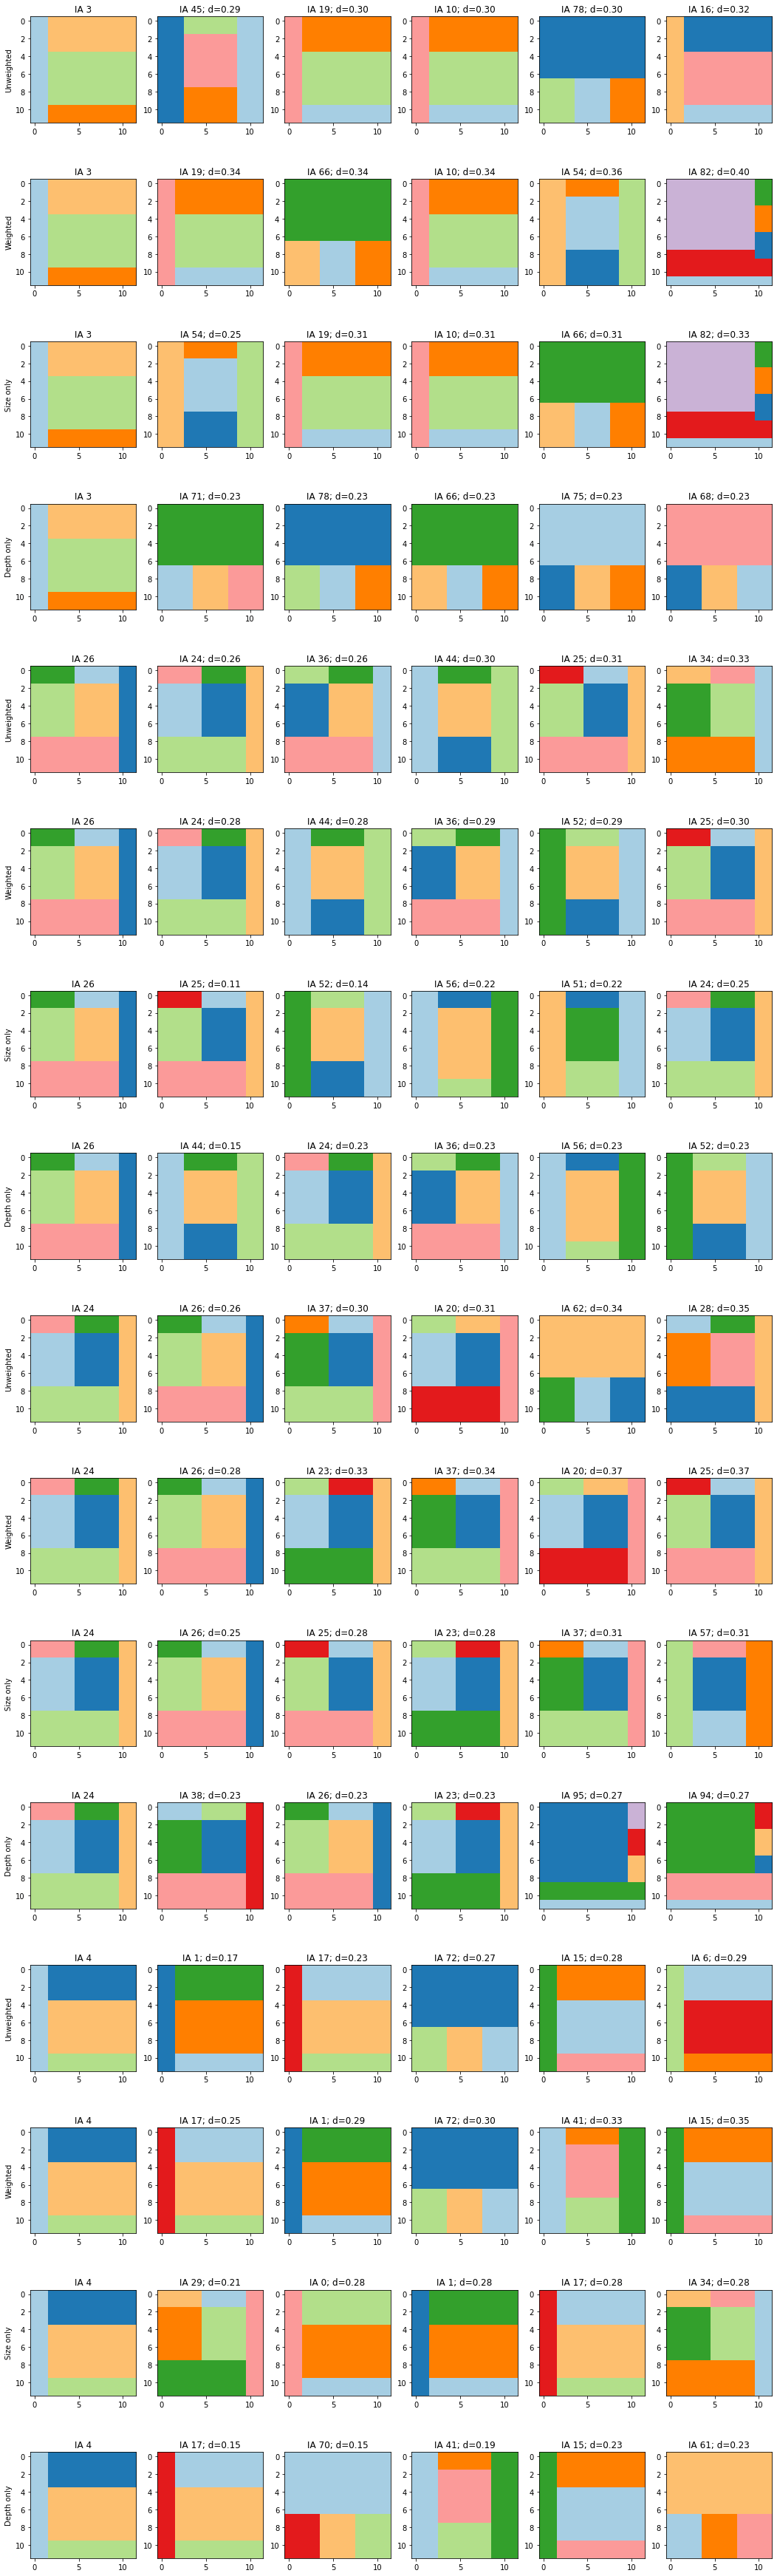

In [55]:
# Plotting 6 most similar
fig, axs = plt.subplots(16, 6, figsize=(6 * 3, 16 * 4))
for i, db_idx in enumerate(chosen_dbs):
    for (j, dist_matrix), ylab in zip(enumerate([distances, distances_weighted, distances_size_only, distances_depth_only]),
                                      ['Unweighted', 'Weighted', 'Size only', 'Depth only']):
        plot_treemap(treemaps[db_idx], ax=axs[i*4 + j, 0])
        axs[i*4 + j, 0].set_title(f"IA {db_idx}")
        axs[i*4 + j, 0].set_ylabel(ylab)

        dists = dist_matrix[db_idx]
        closest_dbs = np.argsort(dists)[1:6]    
        for k, db in enumerate(closest_dbs):
            plot_treemap(treemaps[db], ax=axs[i*4 + j, k + 1])
            axs[i*4 + j, k + 1].set_title(f"IA {db}; d={dists[db]:.2f}")

## Trying different weights

In [60]:
weightsA = np.array([.7, .1, .2])
weightsB = np.array([.2, .1, .7])
weightsC = np.array([.5, 0, .5])
weightsD = np.array([.8, .1, .1])

dist_mats = []
for weights in [weightsA, weightsB, weightsC, weightsD]:
    distances_weighted_i = compute_distances(info_archs, distance_func=weighted_distance, args=(weights,))
    distances_weighted_i /= distances_weighted_i.max()
    dist_mats.append(distances_weighted_i)

100%|██████████| 9216/9216 [04:01<00:00, 38.18it/s]


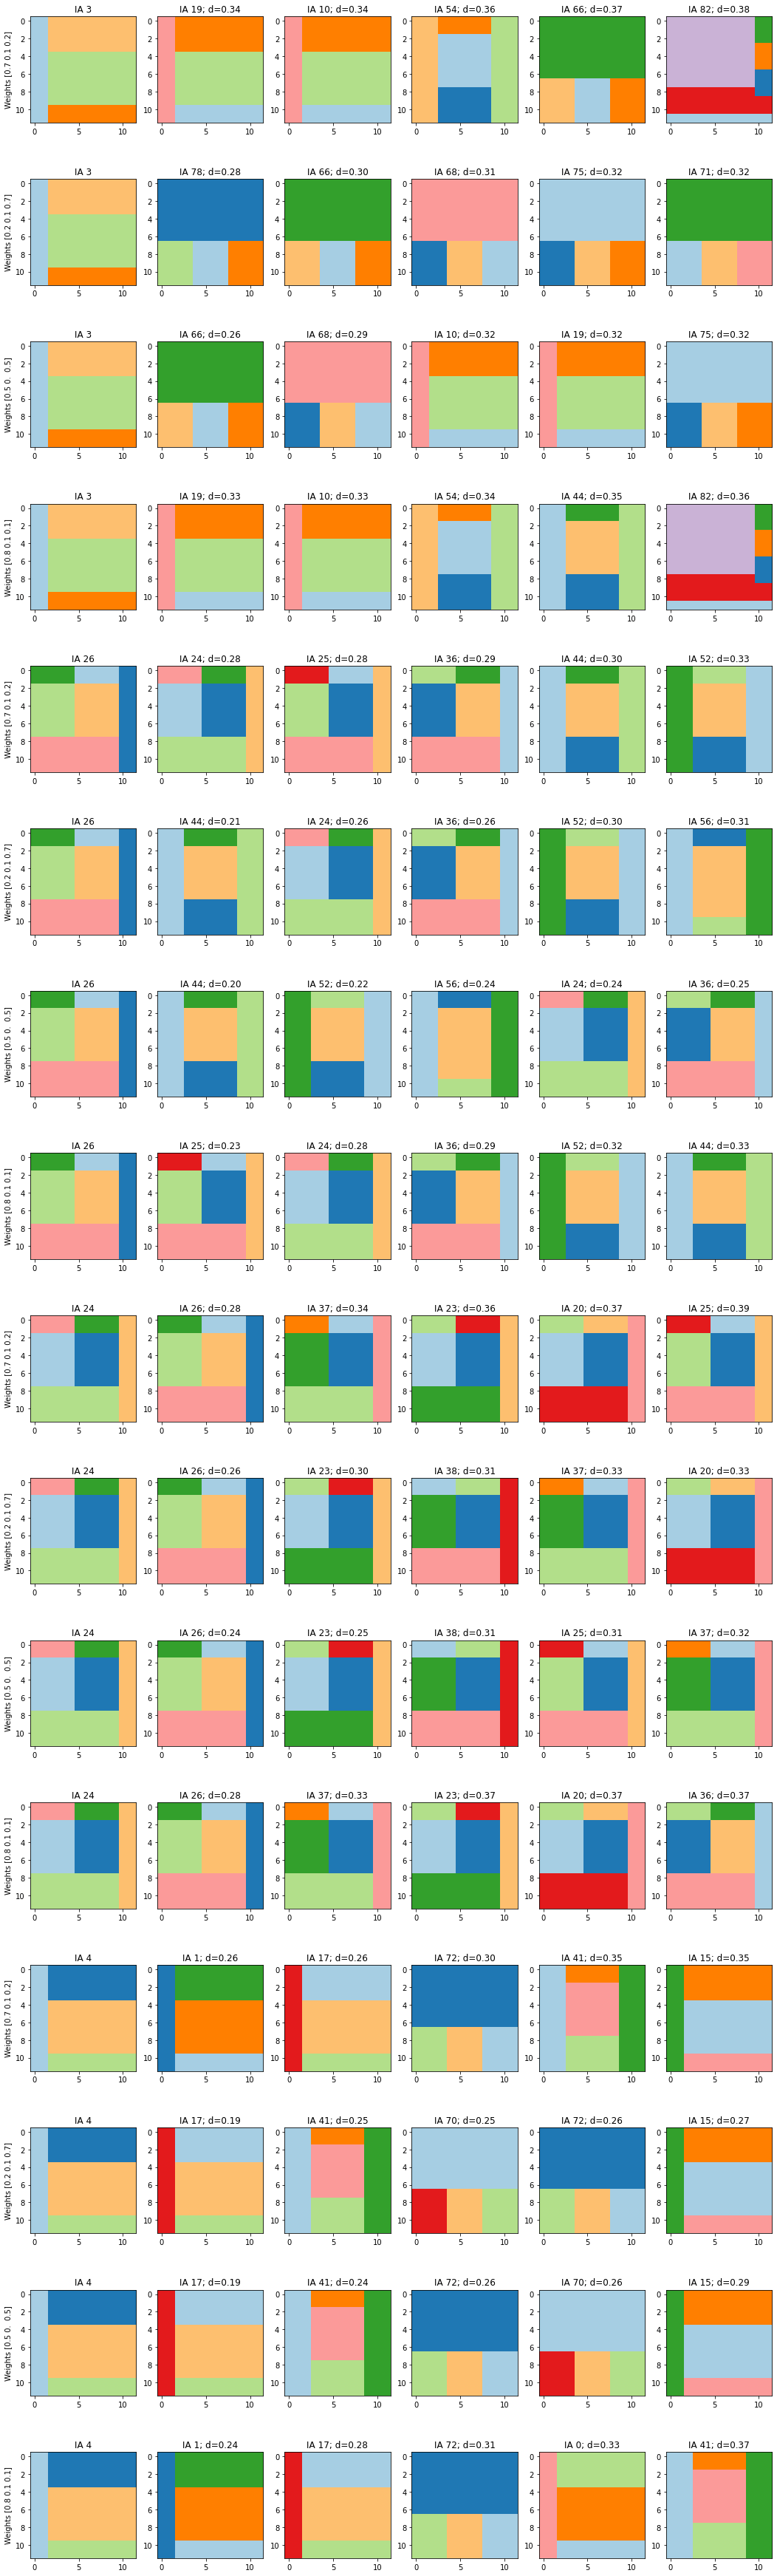

In [61]:
# Plotting 6 most similar
fig, axs = plt.subplots(16, 6, figsize=(6 * 3, 16 * 4))
for i, db_idx in enumerate(chosen_dbs):
    for (j, dist_matrix), weights in zip(enumerate(dist_mats),
                                      [weightsA, weightsB, weightsC, weightsD]):
        plot_treemap(treemaps[db_idx], ax=axs[i*4 + j, 0])
        axs[i*4 + j, 0].set_title(f"IA {db_idx}")
        axs[i*4 + j, 0].set_ylabel(f'Weights {weights}')

        dists = dist_matrix[db_idx]
        closest_dbs = np.argsort(dists)[1:6]    
        for k, db in enumerate(closest_dbs):
            plot_treemap(treemaps[db], ax=axs[i*4 + j, k + 1])
            axs[i*4 + j, k + 1].set_title(f"IA {db}; d={dists[db]:.2f}")